# CIFAR-10 Analysis with CNN and H2O AutoML

This notebook provides a detailed procedure to analyze the CIFAR-10 dataset, build a simple CNN model using Keras, and apply H2O's AutoML for automated machine learning.

Dataset - https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

## Exploratory Data Analysis (EDA)

The EDA phase involves loading the dataset, understanding its structure, visualizing some samples, and checking the distribution of classes.

In [ ]:
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-10-31 07:14:17--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  46.6MB/s    in 3.9s    

2023-10-31 07:14:21 (41.8 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [ ]:
# Extracting the CIFAR-10 dataset
with tarfile.open('/content/cifar-10-python.tar.gz', 'r:gz') as tar:
    tar.extractall()

# Function to load a batch of CIFAR-10 data
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
        Y = np.array(Y)
        return X, Y

In [ ]:
# Load the batches
X_train, Y_train = [], []
for i in range(1, 6):
    X_batch, Y_batch = load_cifar10_batch(f'cifar-10-batches-py/data_batch_{i}')
    X_train.append(X_batch)
    Y_train.append(Y_batch)

# Stacking batches to form a complete training set
X_train = np.vstack(X_train)
Y_train = np.hstack(Y_train)

In [ ]:
# Loading test data
X_test, Y_test = load_cifar10_batch('cifar-10-batches-py/test_batch')

# Getting the class names
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    label_names = pickle.load(f, encoding='latin1')
    class_names = label_names['label_names']

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, class_names

((50000, 32, 32, 3),
 (50000,),
 (10000, 32, 32, 3),
 (10000,),
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

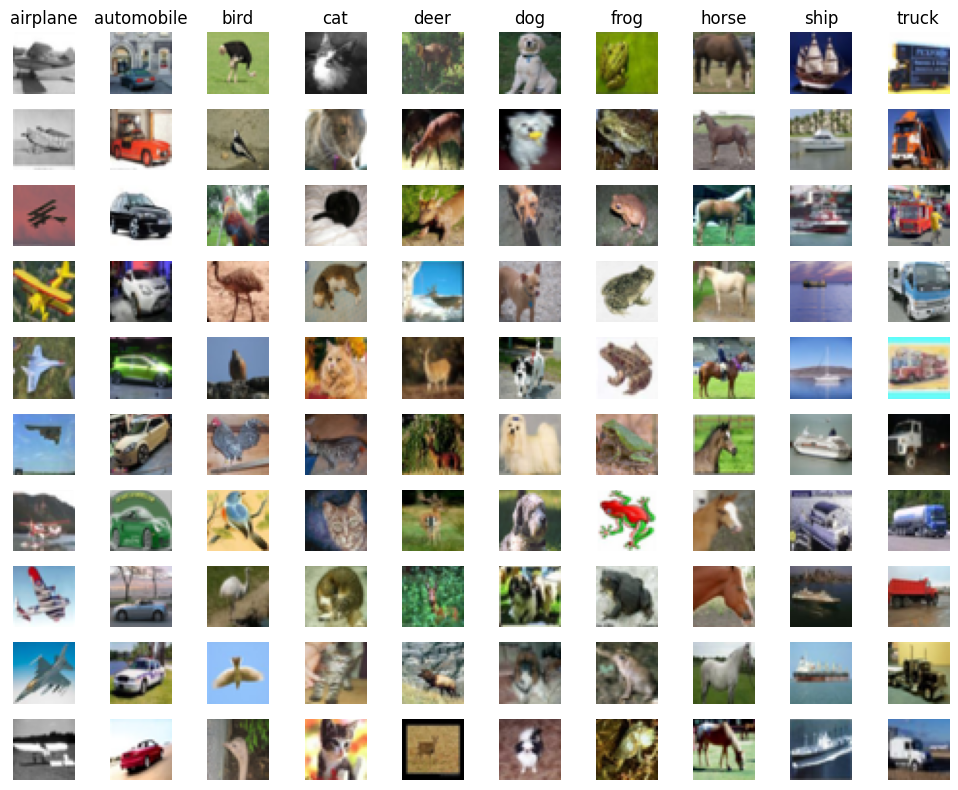

In [ ]:
# Function to visualize samples from each class
def visualize_samples(X, Y, class_names, samples_per_class=10):
    num_classes = len(class_names)
    plt.figure(figsize=(10, 8))

    for y, cls in enumerate(class_names):
        idxs = np.flatnonzero(Y == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.tight_layout()
    plt.show()

# Visualizing the samples
visualize_samples(X_train, Y_train, class_names)


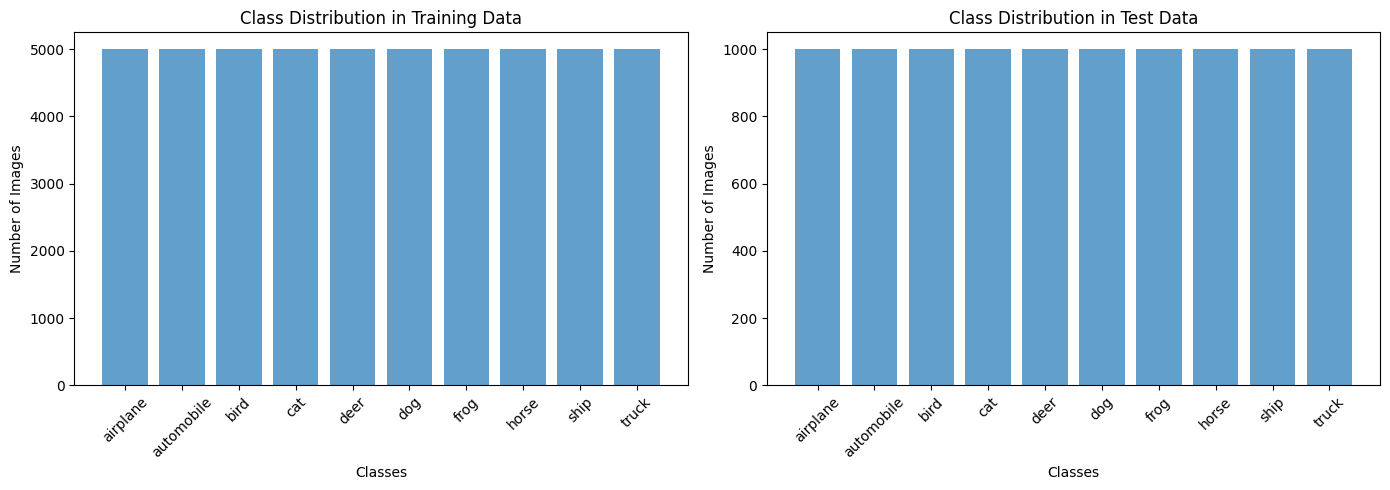

In [ ]:
# Function to visualize class distribution
def visualize_class_distribution(Y_train, Y_test, class_names):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    # Training data distribution
    axes[0].hist(Y_train, bins=np.arange(-0.5, 10.5, 1), rwidth=0.8, align='mid', alpha=0.7)
    axes[0].set_xticks(np.arange(10))
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_title('Class Distribution in Training Data')
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Number of Images')

    # Test data distribution
    axes[1].hist(Y_test, bins=np.arange(-0.5, 10.5, 1), rwidth=0.8, align='mid', alpha=0.7)
    axes[1].set_xticks(np.arange(10))
    axes[1].set_xticklabels(class_names, rotation=45)
    axes[1].set_title('Class Distribution in Test Data')
    axes[1].set_xlabel('Classes')
    axes[1].set_ylabel('Number of Images')

    plt.tight_layout()
    plt.show()

# Visualizing the class distribution
visualize_class_distribution(Y_train, Y_test, class_names)


## Data Preprocessing

In this phase, we'll normalize the images, one-hot encode the labels, and split the dataset into training, validation, and test sets.

1.  Normalize the Images

In [ ]:
# Normalize the images
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

X_train_normalized.shape, X_test_normalized.shape


((50000, 32, 32, 3), (10000, 32, 32, 3))

2. One-hot Encode the Labels

In [ ]:
from keras.utils import to_categorical

# One-hot encoding the labels
Y_train_encoded = to_categorical(Y_train, num_classes=10)
Y_test_encoded = to_categorical(Y_test, num_classes=10)

Y_train_encoded.shape, Y_test_encoded.shape


((50000, 10), (10000, 10))

Splitting the Training Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the training data into training and validation sets
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train_normalized, Y_train_encoded, test_size=0.1, random_state=42
)

X_train_final.shape, X_val.shape, Y_train_final.shape, Y_val.shape


((45000, 32, 32, 3), (5000, 32, 32, 3), (45000, 10), (5000, 10))

## Building a CNN Model with Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create the model
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_final, Y_train_final, epochs=5, batch_size=32, validation_data=(X_val, Y_val))


Epoch 1/5
1407/1407 [==============================] - 100s 70ms/step - loss: 1.3585 - accuracy: 0.5141 - val_loss: 1.1699 - val_accuracy: 0.5772
Epoch 2/5
1407/1407 [==============================] - 103s 73ms/step - loss: 0.9871 - accuracy: 0.6517 - val_loss: 0.9274 - val_accuracy: 0.6694
Epoch 3/5
1407/1407 [==============================] - 99s 70ms/step - loss: 0.7976 - accuracy: 0.7197 - val_loss: 0.9146 - val_accuracy: 0.6818
Epoch 4/5
1407/1407 [==============================] - 99s 70ms/step - loss: 0.6418 - accuracy: 0.7761 - val_loss: 0.8253 - val_accuracy: 0.7112
Epoch 5/5
1407/1407 [==============================] - 99s 70ms/step - loss: 0.4970 - accuracy: 0.8253 - val_loss: 0.9270 - val_accuracy: 0.7044


### Trained CNN with cross validation accuracy 70.44%

## AutoML with H2O

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.1-py2.py3-none-any.whl size=257484150 sha256=c020a81dc934a3f58bf9e05c05d3faa9eac0cab917e8cbb295ff84e1a267bf80
  Stored in directory: /root/.cache/pip/wheels/d9/9b/ca/7345b72d17e1e17da37239d70631c3214ec9e541b0c9e700e2
Successfully built h2o


In [ ]:
import h2o
from h2o.automl import H2OAutoML

# Initialize the H2O cluster
h2o.init()

# Convert data to H2OFrame
train_h2o = h2o.H2OFrame(X_train_final)
val_h2o = h2o.H2OFrame(X_val)
test_h2o = h2o.H2OFrame(X_test_normalized)

# Set target and predictors
target = 'label'
predictors = train_h2o.columns.remove(target)

# AutoML Configuration
aml = H2OAutoML(max_runtime_secs=600, seed=42, project_name='CIFAR10')

# Model Training
aml.train(x=predictors, y=target, training_frame=train_h2o, leaderboard_frame=val_h2o)

# Leaderboard
lb = aml.leaderboard
print(lb)

# Predictions
preds = aml.leader.predict(test_h2o)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyil7zel4
  JVM stdout: /tmp/tmpyil7zel4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyil7zel4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,"14 days, 21 hours and 10 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_z5s7ov
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"
